# 注意力提示

In [10]:
import torch

In [11]:
import torch
import matplotlib.pyplot as plt
from typing import List

def show_heatmaps(matrices: torch.Tensor, 
                  xlabel: str, 
                  ylabel: str, 
                  titles: List[str] = None, 
                  figsize: tuple = (2.5, 2.5),
                  cmap: str = 'Reds'):
    """
    显示矩阵热图 (不依赖d2l包)。
    :param matrices: 张量，形状为 (要显示的行数, 要显示的列数, 查询数, 键数)。
    :param xlabel: x轴标签。
    :param ylabel: y轴标签。
    :param titles: 每个子图的标题列表。
    :param figsize: 图像的整体大小。
    :param cmap: Matplotlib的颜色映射方案。
    """
    # 1. 获取矩阵网格的行列数
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    
    # 2. 创建子图网格 (用 plt.subplots 替代 d2l.plt.subplots)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    
    # 3. 遍历每个子图和对应的矩阵数据
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            # 4. 绘制热图
            # ax.imshow 是matplotlib的核心函数，用于将矩阵显示为图像
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            
            # 5. 设置坐标轴标签和标题
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
                
    # 6. 为整个图像添加一个颜色条
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    
    # 7. 显示图像
    plt.show()

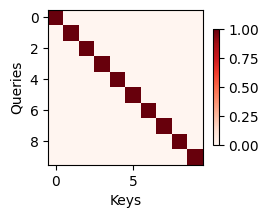

In [12]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# 注意力汇聚：Nadaraya-Watson 核回归

In [13]:
import torch
from torch import nn

In [14]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_kernel_reg(y_hat: torch.Tensor):
    """
    绘制核回归的结果图 (不依赖d2l包)。
    此函数假定 x_test, y_truth, x_train, y_train 变量已在外部定义。
    
    :param y_hat: 模型的预测值张量。
    """
    # 1. 创建一个画布
    plt.figure(figsize=(7, 5))
    
    # 2. 绘制真实函数曲线 (蓝色实线)
    # 假设 x_test 和 y_truth 已定义
    plt.plot(x_test.numpy(), y_truth.numpy(), label='Truth', color='b')
    
    # 3. 绘制模型的预测曲线 (红色虚线)
    plt.plot(x_test.numpy(), y_hat.numpy(), label='Pred', color='r', linestyle='--')
    
    # 4. 绘制训练数据点 (绿色半透明圆点)
    # 假设 x_train 和 y_train 已定义
    plt.plot(x_train.numpy(), y_train.numpy(), 'o', alpha=0.5, label='Training Points', color='g')
    
    # 5. 设置图表的坐标轴范围、标签和图例
    plt.xlim([0, 5])
    plt.ylim([-1, 5])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.title('Kernel Regression Result')
    
    # 6. 显示最终的图像
    plt.show()

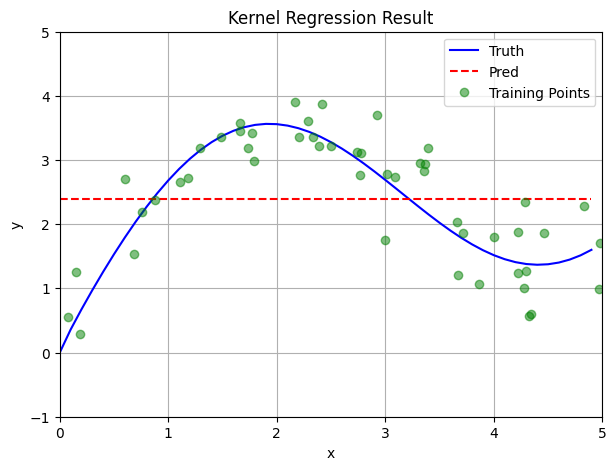

In [16]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

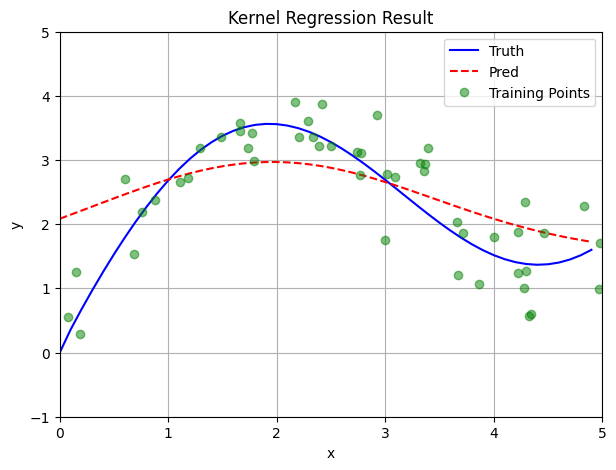

In [17]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

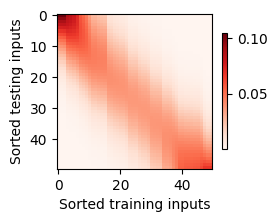

In [18]:
show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [19]:
x_test.shape

torch.Size([50])

In [20]:
n_train

50

In [21]:
x_test.repeat_interleave(n_train).shape

torch.Size([2500])

In [22]:
x_test.repeat_interleave(n_train).reshape((-1, n_train))

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [4.7000, 4.7000, 4.7000,  ..., 4.7000, 4.7000, 4.7000],
        [4.8000, 4.8000, 4.8000,  ..., 4.8000, 4.8000, 4.8000],
        [4.9000, 4.9000, 4.9000,  ..., 4.9000, 4.9000, 4.9000]])

In [23]:
x_train

tensor([0.0773, 0.1524, 0.1872, 0.6053, 0.6813, 0.7596, 0.8815, 1.1072, 1.1847,
        1.2941, 1.4819, 1.6605, 1.6640, 1.7350, 1.7673, 1.7894, 2.1644, 2.2039,
        2.2892, 2.3313, 2.3924, 2.4132, 2.5039, 2.7373, 2.7670, 2.7758, 2.9280,
        3.0013, 3.0193, 3.0875, 3.3243, 3.3523, 3.3699, 3.3892, 3.6574, 3.6706,
        3.7131, 3.8640, 4.0021, 4.2237, 4.2259, 4.2817, 4.2880, 4.2977, 4.3282,
        4.3398, 4.4614, 4.8305, 4.9718, 4.9819])

In [24]:
x_test.repeat_interleave(n_train).reshape((-1, n_train)) - x_train

tensor([[-0.0773, -0.1524, -0.1872,  ..., -4.8305, -4.9718, -4.9819],
        [ 0.0227, -0.0524, -0.0872,  ..., -4.7305, -4.8718, -4.8819],
        [ 0.1227,  0.0476,  0.0128,  ..., -4.6305, -4.7718, -4.7819],
        ...,
        [ 4.6227,  4.5476,  4.5128,  ..., -0.1305, -0.2718, -0.2819],
        [ 4.7227,  4.6476,  4.6128,  ..., -0.0305, -0.1718, -0.1819],
        [ 4.8227,  4.7476,  4.7128,  ...,  0.0695, -0.0718, -0.0819]])

In [25]:
nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)[1, :].sum()

tensor(1.)

In [26]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

# torch.Size([2, 1, 6])

torch.Size([2, 1, 6])

In [27]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

# tensor([[[ 4.5000]],

#         [[14.5000]]])

tensor([[[ 4.5000]],

        [[14.5000]]])

In [28]:
weights.shape, values.shape

(torch.Size([2, 10]), torch.Size([2, 10]))

In [29]:
weights.unsqueeze(1).shape

torch.Size([2, 1, 10])

In [30]:
values.unsqueeze(-1).shape

torch.Size([2, 10, 1])

In [31]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [32]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

开始训练...
epoch 1, loss 47.498146
epoch 2, loss 15.818303
epoch 3, loss 15.711432
epoch 4, loss 15.604617
epoch 5, loss 15.498022
训练完成。


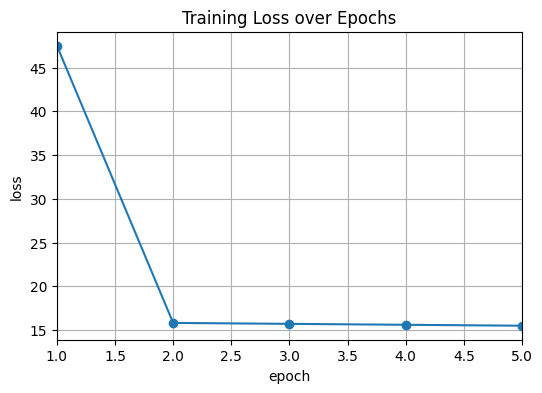

In [33]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)

# 移除 d2l.Animator，创建一个列表来存储每个epoch的损失
losses = [] 
print("开始训练...")
for epoch in range(5):
    trainer.zero_grad()
    # 在这个例子中，我们在训练集上计算损失
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    
    current_loss = float(l.sum())
    # 将当前epoch的损失添加到列表中
    losses.append(current_loss)
    
    print(f'epoch {epoch + 1}, loss {current_loss:.6f}')

print("训练完成。")

# 4. [新增] 训练结束后使用matplotlib绘图
plt.figure(figsize=(6, 4))
plt.plot(range(1, 6), losses, marker='o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim([1, 5])
plt.grid(True)
plt.title('Training Loss over Epochs')
plt.show()

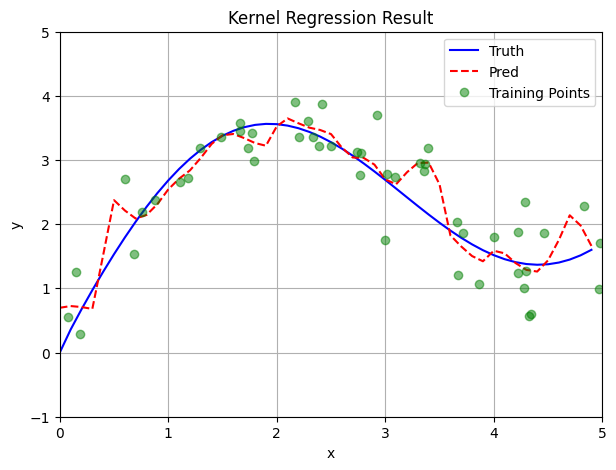

In [34]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

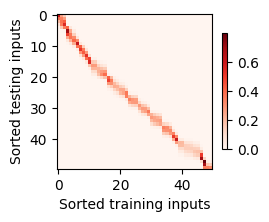

In [35]:
show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# 注意力评分函数

In [36]:
import math
import torch
from torch import nn

In [37]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [38]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

# tensor([[[0.3873, 0.6127, 0.0000, 0.0000],
#          [0.5202, 0.4798, 0.0000, 0.0000]],

#         [[0.3233, 0.2558, 0.4209, 0.0000],
#          [0.3772, 0.2677, 0.3552, 0.0000]]])

tensor([[[0.4815, 0.5185, 0.0000, 0.0000],
         [0.3711, 0.6289, 0.0000, 0.0000]],

        [[0.2429, 0.3763, 0.3808, 0.0000],
         [0.2027, 0.3780, 0.4192, 0.0000]]])

In [39]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

# tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
#          [0.2357, 0.4599, 0.3044, 0.0000]],

#         [[0.5612, 0.4388, 0.0000, 0.0000],
#          [0.3005, 0.1596, 0.2777, 0.2622]]])

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2542, 0.2930, 0.4528, 0.0000]],

        [[0.4452, 0.5548, 0.0000, 0.0000],
         [0.3255, 0.2511, 0.1639, 0.2595]]])

In [40]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [41]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

# tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

#         [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

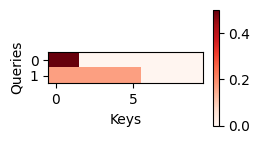

In [42]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [43]:
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [44]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

# tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

#         [[10.0000, 11.0000, 12.0000, 13.0000]]])

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

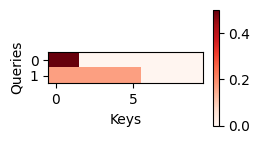

In [45]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

# Bahdanau 注意力

In [90]:
import torch
from torch import nn

In [91]:
import os
import zipfile
import urllib.request
import collections
from torch.utils.data import TensorDataset, DataLoader

def read_data_nmt():
    """
    超稳健版：载入“英语－法语”数据集。
    通过在解压前主动检查压缩包内容来精确定位和提取文件。
    """
    # 1. 设置路径
    data_url = 'http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip'
    data_dir = os.path.join('.', 'data')
    zip_path = os.path.join(data_dir, 'fra-eng.zip')
    # 最终的目标文件路径，我们期望它始终是 ./data/fra.txt
    target_file_path = os.path.join(data_dir, 'fra.txt')

    # 2. 确保数据目录存在
    os.makedirs(data_dir, exist_ok=True)

    # 3. 检查最终文件是否存在
    if not os.path.exists(target_file_path):
        print(f'目标文件 "{target_file_path}" 不存在，开始处理...')

        # 4. 确保zip文件已下载
        if not os.path.exists(zip_path):
            print(f'正在从 {data_url} 下载数据...')
            try:
                urllib.request.urlretrieve(data_url, zip_path)
                print(f'下载完成，文件保存在 "{zip_path}"')
            except Exception as e:
                print(f"下载失败: {e}")
                return None
        
        # 5. [核心修改] 智能检查并解压
        print(f'正在检查压缩包 "{zip_path}" 的内容...')
        try:
            with zipfile.ZipFile(zip_path, 'r') as z:
                # 获取zip包内所有文件的列表，用于调试和定位
                file_list = z.namelist()
                print(f'>>> 压缩包中的文件列表: {file_list}')

                # 从列表中寻找我们需要的.txt文件
                txt_file_in_zip = None
                for filename in file_list:
                    if filename.endswith('.txt'):
                        txt_file_in_zip = filename
                        print(f'>>> 在压缩包中找到目标文件: "{txt_file_in_zip}"')
                        break

                if txt_file_in_zip:
                    # 使用 extract 方法精确解压单个文件到 data_dir
                    z.extract(txt_file_in_zip, path=data_dir)
                    
                    # 解压后，文件的实际路径是 os.path.join(data_dir, txt_file_in_zip)
                    # 例如，如果zip包里是 'folder/fra.txt'，这里就会是 './data/folder/fra.txt'
                    extracted_file_actual_path = os.path.join(data_dir, txt_file_in_zip)
                    print(f'>>> 文件已解压到: "{extracted_file_actual_path}"')

                    # [重要] 如果解压后的路径不是我们期望的最终路径，就重命名/移动它
                    if os.path.normpath(extracted_file_actual_path) != os.path.normpath(target_file_path):
                        print(f'>>> 调整文件位置: 从 "{extracted_file_actual_path}" 移动到 "{target_file_path}"')
                        os.rename(extracted_file_actual_path, target_file_path)
                    print('>>> 文件已就绪。')
                else:
                    print("错误：在压缩包中未找到任何 .txt 文件。")
                    return None
        except Exception as e:
            print(f"处理压缩包时出错: {e}")
            return None
    else:
        print(f'文件 "{target_file_path}" 已存在，直接读取。')

    # 6. 读取文件
    try:
        with open(target_file_path, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        print(f"最终读取失败，文件 '{target_file_path}' 仍不存在。脚本无法自动解决此问题。")
        return None


#@save
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)


#@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target


class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充


#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len


#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    # 使用 PyTorch 的 DataLoader 替代 d2l.load_array
    dataset = TensorDataset(*data_arrays)
    data_iter = DataLoader(dataset, batch_size, shuffle=True)
    return data_iter, src_vocab, tgt_vocab

In [92]:
from torch import nn


#@save
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError


#@save
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError


#@save
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [93]:
from torch import nn


#@save
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError


#@save
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError


#@save
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)


#@save
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state


class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state


def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X


class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [94]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型 (不依赖d2l包)"""
    import time
    
    # --- 1. 初始化 ---
    
    # 定义权重初始化函数
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    
    # 用于存储每个epoch的损失，以便后续绘图
    epoch_losses = []
    
    print("开始训练...")
    for epoch in range(num_epochs):
        # --- 2. 训练一个 Epoch ---
        start_time = time.time()
        # 替代 d2l.Accumulator
        total_loss = 0
        total_tokens = 0
        
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            
            # 准备解码器的输入（强制教学）
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            
            # 前向传播
            Y_hat, _ = net(X, dec_input, X_valid_len)
            
            # 计算损失
            l = loss(Y_hat, Y, Y_valid_len)
            l = l.sum()
            
            # 反向传播
            l.backward()
            
            # 梯度裁剪 (替代 d2l.grad_clipping)
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            
            # 累加损失和词元数
            total_loss += l.item()
            total_tokens += num_tokens.item()

        # --- 3. 记录和打印 Epoch 信息 ---
        duration = time.time() - start_time
        avg_loss = total_loss / total_tokens
        epoch_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, '
                  f'Loss: {avg_loss:.3f}, '
                  f'{total_tokens / duration:.1f} tokens/sec on {str(device)}')

    print("训练完成。")

    # --- 4. 训练后绘图 ---
    print("绘制损失曲线...")
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.title('Training Loss Curve')
    plt.show()

In [95]:
#@save
class AttentionDecoder(Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [96]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [97]:
#@save
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

文件 "./data/fra.txt" 已存在，直接读取。
开始训练...
Epoch 10/250, Loss: 0.204, 2386.4 tokens/sec on mps
Epoch 20/250, Loss: 0.141, 3036.8 tokens/sec on mps
Epoch 30/250, Loss: 0.107, 2335.6 tokens/sec on mps
Epoch 40/250, Loss: 0.082, 3029.0 tokens/sec on mps
Epoch 50/250, Loss: 0.067, 3037.8 tokens/sec on mps
Epoch 60/250, Loss: 0.057, 2414.0 tokens/sec on mps
Epoch 70/250, Loss: 0.047, 3060.0 tokens/sec on mps
Epoch 80/250, Loss: 0.041, 2573.3 tokens/sec on mps
Epoch 90/250, Loss: 0.038, 2847.1 tokens/sec on mps
Epoch 100/250, Loss: 0.033, 2753.3 tokens/sec on mps
Epoch 110/250, Loss: 0.031, 1658.3 tokens/sec on mps
Epoch 120/250, Loss: 0.028, 2630.4 tokens/sec on mps
Epoch 130/250, Loss: 0.027, 2901.2 tokens/sec on mps
Epoch 140/250, Loss: 0.026, 2382.2 tokens/sec on mps
Epoch 150/250, Loss: 0.026, 1865.2 tokens/sec on mps
Epoch 160/250, Loss: 0.025, 2997.3 tokens/sec on mps
Epoch 170/250, Loss: 0.023, 2932.6 tokens/sec on mps
Epoch 180/250, Loss: 0.023, 2316.2 tokens/sec on mps
Epoch 190/250, Lo

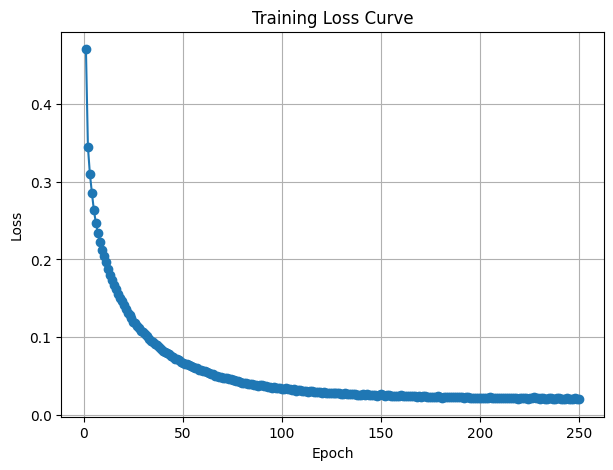

In [98]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, "mps"

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [99]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [102]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充


#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')

# go . => va !,  bleu 1.000
# i lost . => j'ai perdu .,  bleu 1.000
# he's calm . => il court .,  bleu 0.000
# i'm home . => je suis chez moi .,  bleu 1.000

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il court .,  bleu 0.000
i'm home . => je suis chez moi .,  bleu 1.000


In [104]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

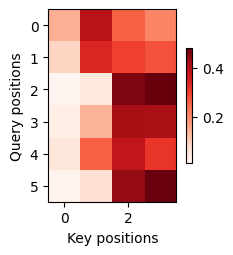

In [105]:
# 加上一个包含序列结束词元
show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

# 多头注意力

In [106]:
import math
import torch
from torch import nn

In [107]:
#@save
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [108]:
#@save
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [ ]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

# MultiHeadAttention(
#   (attention): DotProductAttention(
#     (dropout): Dropout(p=0.5, inplace=False)
#   )
#   (W_q): Linear(in_features=100, out_features=100, bias=False)
#   (W_k): Linear(in_features=100, out_features=100, bias=False)
#   (W_v): Linear(in_features=100, out_features=100, bias=False)
#   (W_o): Linear(in_features=100, out_features=100, bias=False)
# )

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [ ]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

# torch.Size([2, 4, 100])

torch.Size([2, 4, 100])

# 自注意力和位置编码

In [111]:
import math
import torch
from torch import nn

In [ ]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

# MultiHeadAttention(
#   (attention): DotProductAttention(
#     (dropout): Dropout(p=0.5, inplace=False)
#   )
#   (W_q): Linear(in_features=100, out_features=100, bias=False)
#   (W_k): Linear(in_features=100, out_features=100, bias=False)
#   (W_v): Linear(in_features=100, out_features=100, bias=False)
#   (W_o): Linear(in_features=100, out_features=100, bias=False)
# )

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [ ]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

# torch.Size([2, 4, 100])

torch.Size([2, 4, 100])

In [114]:
#@save
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

正在使用matplotlib绘制位置编码曲线...


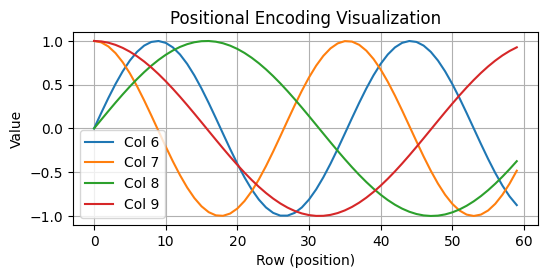

In [117]:
# 定义参数
encoding_dim, num_steps = 32, 60
# 实例化我们自己的PositionalEncoding类
# 注意：原版d2l中dropout是第二个参数，我们在此保持一致
pos_encoding = PositionalEncoding(num_hiddens=encoding_dim, dropout=0)
pos_encoding.eval() # 设置为评估模式，关闭dropout
# 运行一次前向传播以获得编码后的张量X
# P矩阵是在__init__中预先计算好的
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
# 准备绘图数据
x_axis = torch.arange(num_steps)
# 选择要绘制的维度（列）
columns_to_plot = torch.arange(6, 10)
plot_data = P[0, :, columns_to_plot].numpy()
# 使用matplotlib绘图
import matplotlib.pyplot as plt
print("正在使用matplotlib绘制位置编码曲线...")
plt.figure(figsize=(6, 2.5))
for i in range(plot_data.shape[1]):
    plt.plot(x_axis, plot_data[:, i], label=f"Col {columns_to_plot[i].item()}")
plt.xlabel('Row (position)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.title('Positional Encoding Visualization')
plt.show()

In [ ]:
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

# 0的二进制是：000
# 1的二进制是：001
# 2的二进制是：010
# 3的二进制是：011
# 4的二进制是：100
# 5的二进制是：101
# 6的二进制是：110
# 7的二进制是：111

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


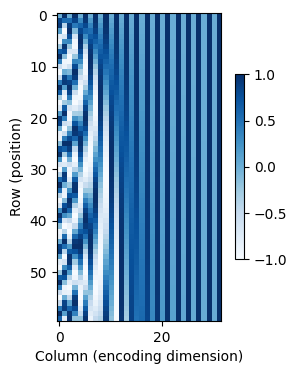

In [119]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

# Transformer

In [120]:
import math
import pandas as pd
import torch
from torch import nn

In [121]:
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [ ]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

# tensor([[-0.5029, -0.0346, -0.5475, -0.1604, -0.6394,  0.6031,  0.3236, -0.0592],
#         [-0.5029, -0.0346, -0.5475, -0.1604, -0.6394,  0.6031,  0.3236, -0.0592],
#         [-0.5029, -0.0346, -0.5475, -0.1604, -0.6394,  0.6031,  0.3236, -0.0592]],
#        grad_fn=<SelectBackward0>)

tensor([[-0.5029, -0.0346, -0.5475, -0.1604, -0.6394,  0.6031,  0.3236, -0.0592],
        [-0.5029, -0.0346, -0.5475, -0.1604, -0.6394,  0.6031,  0.3236, -0.0592],
        [-0.5029, -0.0346, -0.5475, -0.1604, -0.6394,  0.6031,  0.3236, -0.0592]],
       grad_fn=<SelectBackward0>)

In [ ]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

# layer norm: tensor([[-1.0000,  1.0000],
#         [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
# batch norm: tensor([[-1.0000, -1.0000],
#         [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [124]:
#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [ ]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

# torch.Size([2, 3, 4])

torch.Size([2, 3, 4])

In [127]:
#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [ ]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

# torch.Size([2, 100, 24])

torch.Size([2, 100, 24])

In [130]:
#@save
class TransformerEncoder(Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [ ]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

# torch.Size([2, 100, 24])

torch.Size([2, 100, 24])

In [132]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [ ]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

# torch.Size([2, 100, 24])

torch.Size([2, 100, 24])

In [134]:
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

文件 "./data/fra.txt" 已存在，直接读取。
开始训练...
Epoch 10/200, Loss: 0.186, 3358.6 tokens/sec on mps
Epoch 20/200, Loss: 0.136, 4306.0 tokens/sec on mps
Epoch 30/200, Loss: 0.101, 4369.1 tokens/sec on mps
Epoch 40/200, Loss: 0.084, 4579.7 tokens/sec on mps
Epoch 50/200, Loss: 0.071, 4077.3 tokens/sec on mps
Epoch 60/200, Loss: 0.057, 3183.4 tokens/sec on mps
Epoch 70/200, Loss: 0.052, 4069.4 tokens/sec on mps
Epoch 80/200, Loss: 0.050, 4966.9 tokens/sec on mps
Epoch 90/200, Loss: 0.045, 4973.5 tokens/sec on mps
Epoch 100/200, Loss: 0.045, 5022.7 tokens/sec on mps
Epoch 110/200, Loss: 0.041, 3487.3 tokens/sec on mps
Epoch 120/200, Loss: 0.039, 4967.1 tokens/sec on mps
Epoch 130/200, Loss: 0.037, 4611.1 tokens/sec on mps
Epoch 140/200, Loss: 0.036, 3433.4 tokens/sec on mps
Epoch 150/200, Loss: 0.035, 5004.6 tokens/sec on mps
Epoch 160/200, Loss: 0.036, 3520.5 tokens/sec on mps
Epoch 170/200, Loss: 0.034, 4411.0 tokens/sec on mps
Epoch 180/200, Loss: 0.033, 3620.7 tokens/sec on mps
Epoch 190/200, Lo

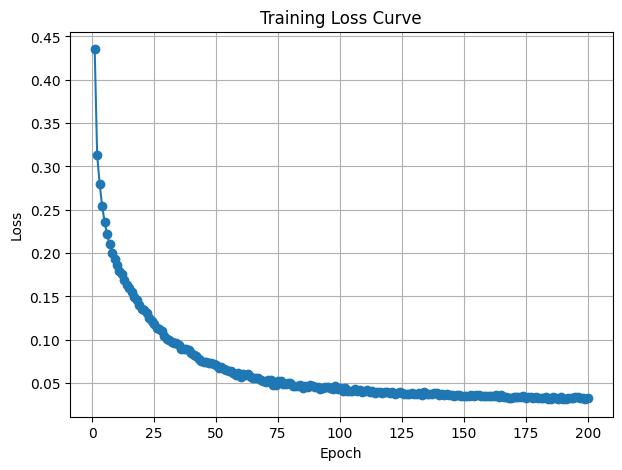

In [136]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, "mps"
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {bleu(translation, fra, k=2):.3f}')


# go . => va !,  bleu 1.000
# i lost . => j'ai perdu .,  bleu 1.000
# he's calm . => il est calme .,  bleu 1.000
# i'm home . => je suis chez moi .,  bleu 1.000

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [ ]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

# torch.Size([2, 4, 10, 10])

torch.Size([2, 4, 10, 10])

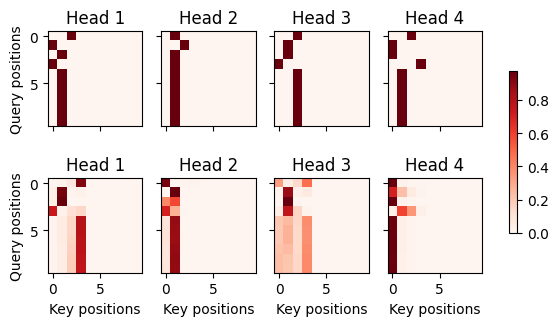

In [140]:
show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [ ]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

# (torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

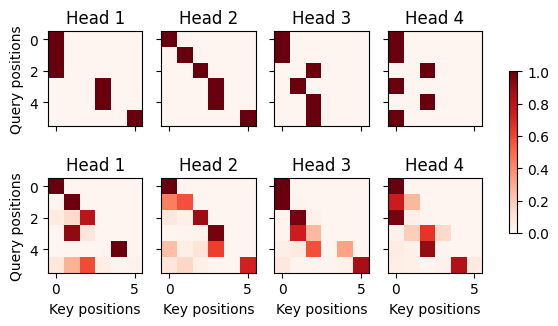

In [142]:
# Plusonetoincludethebeginning-of-sequencetoken
show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

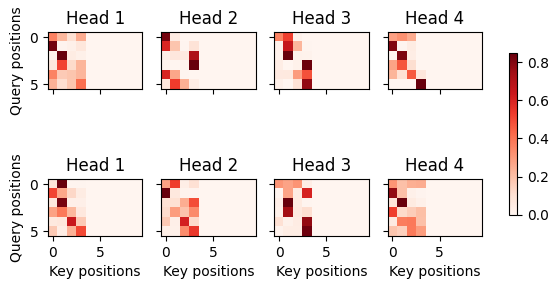

In [143]:
show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))